# ML Engineer: Coding Challenge
_Author:_ Emanuele Sicurella

Applying for Epoch Biodesign

## Introduction

This report presents my approach to the coding challenge for the position of Machine Learning Engineer at Epoch Biodesign. The challenge consists in the analysis and modeling of a dataset of sequence activity data composed of series of amminoacid sequences (proteins) and respective thermostability values, _i.e._, the temperature at which the protein unfolds, ceasing to be active.

I decided to use a Jupyter notebook as it is a great tool for presenting text and working code examples and it can dramatically help following the flow of my reasoning. Following Jupyter best practices, this notebook is designed in a way that can be executed cell after cell without the need for including or modifying code (although, given the interactive nature of a Jupyter notebook, the reader can experiment with slight modifications in the code). Please note that as the notebook is intended to show my step-by-step reasoning and approach, I will import libraries and define functions when needed instead of make all the imports and function definitions at the beginning as usual.

I've included a cell, at the end of the Introduction section, to install all the dependencies needed to complete the full notebook. I've also provided a file _.yml_ with the Conda environment used, as well as a _requirements.txt_ file should the reader wish to create their own environment.

### Structure of the report

This report is divided into three sections;

**Section 1** is focused on exploratory data analysis, including some visualisations to better understand the dataset.

**Section 2** show my first approach for modeling the dataset, using one-hot-encoding for the sequences and a Long-Short-Term Memory recurrent architecture as a predictive model. Even without fine-tuning, the model reaches good performances quantified by an R<sup>2</sup> score of about 0.85.

**Section 3** includes an introduction to another approach using a different encoding method. In particular, I will use the encoder of a pretrained LLM.

### Requirements

The following cell, contains the commands to install all the libraries required to run the whole notebook.

In [ ]:
# Uncomment below if libraries are needed (e.g. if not using the .yml environment file provided)

## This will install dependencies on the current Jupyter kernel
#import sys
#sys.executable
#!sys.executable - m pip install numpy
#!sys.executable - m pip install matplotlib
#!sys.executable - m pip install pandas
#!sys.executable - m pip install scikit-learn
#!sys.executable - m pip install torch
#!sys.executable - m pip install transformers

## Section 1: Exploratory Data Analysis

First, the data needs to be loaded. I used the library `pandas` to read the dataset in _.csv_ format. I specified the optional parameter `encoding = "ISO-8859-1"` because of the presence of at least one non-utf-8 character. I also imported the `pyplot` from the `matplotlib` library to help exploratory data analysis with some visualisations.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
thermostability = pd.read_csv("thermostability.csv", encoding = "ISO-8859-1")

In [4]:
print(len(thermostability))
thermostability.head(10)

261


,name,sequence,thermostability [¡C]
0,variant_1,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,55.0
1,variant_2,KETSPIPQPKTFGPLGNLPLIDKDKPTLSLIKLAEEQGPIFQIHTP...,43.0
2,variant_3,KQASAIPQPKTYGPLKNLPHLEKEQLSQSLWRIADELGPIFRFDFP...,49.0
3,variant_4,KQASAIPQPKTYGPLKNLPHLEKEQLSQSLWRIADELGPIFRFDFP...,39.8
4,variant_5,KQASAIPQPKTYGPLKNLPHLEKEQLSQSLWRIADELGPIFRFDFP...,52.9
5,variant_6,KETSPIPQPKTFGPLGNLPLIDKDKPTLSLIKLAEEQGPIFQIHTP...,48.8
6,variant_7,KQASAIPQPKTYGPLKNLPHLEKEQLSQSLWRIADELGPIFRFDFP...,45.0
7,variant_8,KETSPIPQPKTFGPLGNLPLIDKDKPTLSLIKLAEEQGPIFQIHTP...,48.3
8,variant_9,KETSPIPQPKTFGPLGNLPLIDKDKPTLSLIKLAEEQGPIFQIHTP...,61.5
9,variant_10,KETSPIPQPKTFGPLGNLPLIDKDKPTLSLIKLAEEQGPIFQIHTP...,54.6


The dataset consists of 261 entries. At a first glance, the sequences appear to be in the expected form _i.e._, a list of uppercase letters each referring to a specific amminoacid. The thermostability data is in the form of `float` numbers. To check for potential anomalies in the dataset, I first looked at the distribution of thermostability values.

In [5]:
thermostability.describe()

,thermostability [¡C]
count,261.000000
mean,51.821456
std,5.862987
min,36.000000
25%,47.900000
50%,50.900000
75%,55.900000
max,64.400000


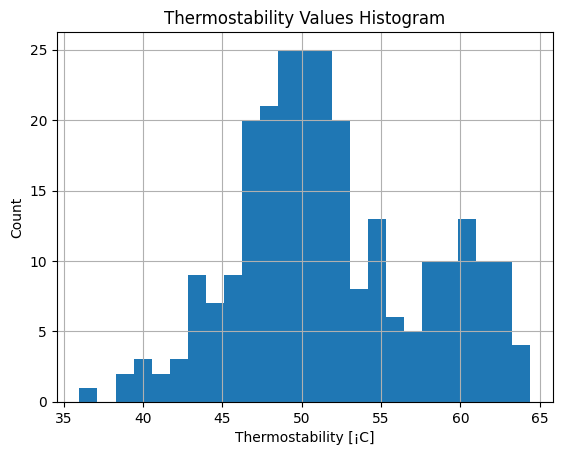

In [6]:
fig, ax = plt.subplots()
ax = thermostability["thermostability [¡C]"].hist(bins = 25)
ax.set_title("Thermostability Values Histogram")
ax.set_ylabel("Count")
ax.set_xlabel("Thermostability [¡C]")

plt.show()

The values appear to follow a Gaussian distribution, except for a a "bump" centered to a value slightly above 60. It might be useful to perform a statistical test (like the $\chi^2$ test) to see to which extent the data effectively follow a Gaussian distribution. This is because some preprocessing methods (like standardisation) are based on the assumption that the data is normally distributed. However, given the time limitation, I won't perform any statistical tests and not use the assumption of normally distributed data.

In addition, the visualisation can be improved. Having more time, I would add vertical dashed lines indicating different percentiles as well as the mean, with respective tick labels. Moreover, I would modify the grid and play with bars filling, contour and colors to make the plot more visually appealing. Similar considerations applies for other visualisations in this report, as I preferred to focus on the predictive modeling using Machine Learning given the limited time.

I checked the length of the sequences adding a column in the dataframe with the respective length of each sequence.

In [7]:
thermostability['seq_length'] = thermostability["sequence"].apply(lambda x: len(x))

In [8]:
thermostability.describe()

,thermostability [¡C],seq_length
count,261.000000,261.0
mean,51.821456,466.0
std,5.862987,0.0
min,36.000000,466.0
25%,47.900000,466.0
50%,50.900000,466.0
75%,55.900000,466.0
max,64.400000,466.0


All of the sequences are of the same length of 466 amminoacid. In general, this is not the case and it might be useful to store the length values in a column of the dataframe.

I also wrote a function to count the occurence of each possible sequence element with two aims in mind. First, to assess the frequency of each amminoacid in the sequences (or the single sequence for comparison). Second, to outline the potential presence of unexpected elements (e.g. imputable to errors or corrupted data).

In [9]:
def get_code_freq(seq_list):
    '''
    Get the frequency of codes (amminoacids) in a list of sequences.

    Parameters:
    ----------
      seq_list (list of str) - list containing the amminoacid sequences.

    Returns:
    -------
      code_freq (dict of str:int) - dictionary of codes (amminoacid) and respective count in the sequences.
    '''

    code_freq = {}
    
    for seq in seq_list:
        for code in seq:
            if code in code_freq.keys():
                code_freq[code] += 1
            else:
                code_freq[code] = 1

    # Arrange (sort) dict items based on dict values in descending  order for easy plotting
    code_freq = dict(sorted(code_freq.items(), key=lambda item: item[1], reverse=True))
                
    return code_freq

In [10]:
code_freq = get_code_freq(thermostability['sequence'])

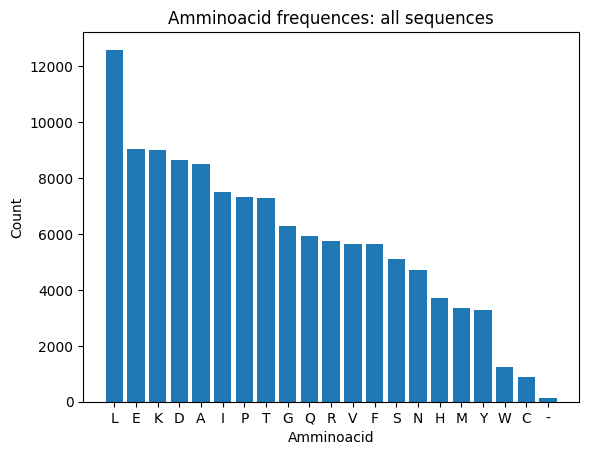

In [11]:
fig, ax = plt.subplots()

ax.bar(code_freq.keys(),code_freq.values())
ax.set_title("Amminoacid frequences: all sequences")
ax.set_ylabel("Count")
ax.set_xlabel("Amminoacid")
plt.show()

The function can be also ran on a single sequence for comparison with the total frequencies.

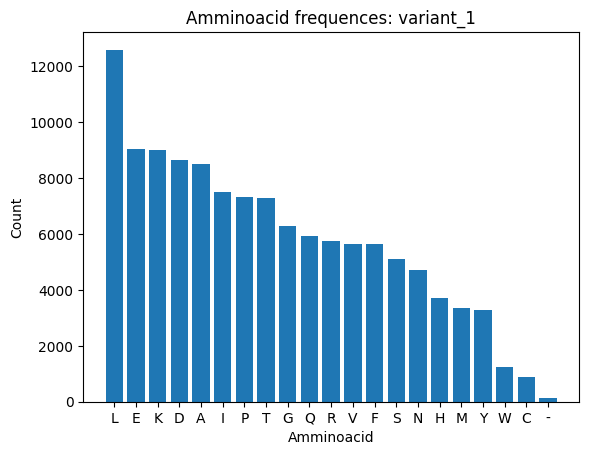

In [13]:
seq = 0
code_freq_seq = get_code_freq(thermostability['sequence'][seq])

fig, ax = plt.subplots()

ax.bar(code_freq.keys(),code_freq.values())
ax.set_title(f"Amminoacid frequences: {thermostability['name'][seq]}")
ax.set_ylabel("Count")
ax.set_xlabel("Amminoacid")
plt.show()

We can see that the sequences contain the usual 20 amminoacid, Leucine being the most common and Cysteine the least, plus a '-' character. In biological sequence data, this character usually indicates a gap character, although it's better to ask the team who generated the data for clarifications. In any case, given the character's low relative frequency, I don't expect to run into issues when using Machine Learning to model the data.

I looked for the gap character in the sequences.

In [14]:
gap_char = {}
for sequence in thermostability['sequence']:
    try:
        if sequence.index('-') in gap_char.keys():
            gap_char[sequence.index('-')] += 1
        else:
            gap_char[sequence.index('-')] = 1
    except ValueError:
        continue

In [15]:
gap_char

{231: 43, 465: 66}

Interestingly, the gap character appears 43 times in the 232nd place and 66 times in the last place of a sequence.

### Considerations on sequence alignment and clustering

Aligning and clustering are typical sequence analysis tools in bioinformatics. Such tools, can be extremely helpful (and even necessary) in some ML preprocessing pipelines. Given the limited time, I didn't perform such analysis, but I will provide an example of why this might be important.

Later in Section 2, when splitting the data into training, validation and test set, I will implicitly use a random splitting. While this may seem a universally correct choice, there might be cases when a splitting of the data should not be performed randomly. By splitting a dataset, we want to minimise the modification in the statistical distribution of the input data. When dealing with protein sequences containing amminoacid mutation, we may have different types or different numbers of mutation. If we perform random splitting, especially with smaller heterogeneous datasets, we may exlcude from the training set a specific kind of mutation or proteins with a higher number of mutations (as they will be less common in the dataset). This will modify the initial statistical distribution of the dataset leading to underperforming models and lower generalisation capabilities. The solution is to use a different splitting strategy like Positional or Mutational splitting (as explained in <a href='https://www.biorxiv.org/content/10.1101/2023.06.18.545472v2.abstract'>Michael, Kæstel-Hansen et al., 2023</a>). For this kind of splitting methods, alignment might be necessary.

Similarly, clustering tecniques might help ensuring that a sufficient number of proteins for each cluster is well represented by samples included in the training set.

While this applies particularly for natural protein sequences, and less in protein engineering settings, I believe it would be worth spending some time discussing with the team who produced the data and with molecular biologists who created the protein, asking in particular the strategy for introducing mutations and the starting natural sequence, if any.


## Section 2: Thermostability prediction using one-hot-encoding and LSTM

In this section, I will fit a bi-directional LSTM on the dataset to predict thermostability values from the specific sequence. LSTM have been the standard architecture for processing sequence data as their simpler counterparts, RNN and GRU, are more suited for shorter sequences or sequence where the relationship between distant elements is less important. Nowadays, transformers and derivate like Large Language Models (LLMs) drastically outperform simpler architectures like LSTMs. However, the simplicity of this method, both conceptually and computationally, make them a great choice for problems involving sequence data which are not extremely complex.

### Data pre-processing

The first pre-processing step to make input data suitable for a ML model is the encoding of the sequences. A typical approach for categorical sequence data (_i.e._, sequences of discrete elements like protein or genome sequences) is to use one-hot-encoding. It works as follow:
1. Identify the number of all possible element of the sequences (aka our dictionary). In this case, we have 20 amminoacid and a '-' character for a total of 21 possible elements.
2. Assign a number to each element. This choice can be arbitrary and the most important thing is to remain consistent.
3. One-hot-encode each possible elementt using a vector of the same dimension of the dictionary, with all zeroes except for a 1 in the position corresponding to the number identifying the element. If $X_n$ with integer $n\in[0,20]$ are our vector representations of the elements and $x_{nm}$ the vector single components, with integer $m\in[0,20]$, we have:

   $X_0 = (x_{0,0}, x_{0,1}, x_{0,2}, \cdots x_{0,20}) = (1, 0, 0 \cdots 0)$
   
   $X_1 = (x_{1,0}, x_{1,1}, x_{1,2}, \cdots x_{1,20}) = (0, 1, 0 \cdots 0)$

   $\cdots$

   $X_{20} = (x_{20,0}, x_{20,1}, x_{20,2}, \cdots x_{20,20}) = (0, 0, 0 \cdots 1)$

I will now apply all the 3 steps to the sequences in the dataset. Please note that the function `torch.nn.F.one_hot` from PyTorch which will be used later, is able to complete all the 3 steps directly on the raw sequences of letters. I decided to explicitly perform step 1 and 2 to show the intermediate positive integer-encoded sequences as well as my theoretical understanding of the process.

Step 1: create a dictionary to assign a positive integer number to each of the 21 components:

In [16]:
codes = list(code_freq.keys())
code_id = {code:i for i,code in enumerate(codes)}
print(code_id)

{'L': 0, 'E': 1, 'K': 2, 'D': 3, 'A': 4, 'I': 5, 'P': 6, 'T': 7, 'G': 8, 'Q': 9, 'R': 10, 'V': 11, 'F': 12, 'S': 13, 'N': 14, 'H': 15, 'M': 16, 'Y': 17, 'W': 18, 'C': 19, '-': 20}


Step 2: encode each sequence using this new representation. I will need to create a new function for this (clearly, it is a very simple function tailored to this specific dataset. A better function will also need to deal with potential missing values or errors either in the sequence or in the code_id dictionary).

In [17]:
def encode_sequences(sequences, code_id):
    '''
    Encode sequences based on a dictionary.

    Parameters:
    ----------
      sequences: list - list containing sequences to encode.

    Returns:
    -------
      encoded_sequences: list - encoded sequences with correspondence from code_id dictionary.
    '''

    encoded_sequences = []
    for seq in sequences:
        new_seq = []
        for code in seq:
            new_seq.append(code_id[code])
        encoded_sequences.append(new_seq)

    return encoded_sequences

In [18]:
encoded_sequences = encode_sequences(thermostability['sequence'], code_id)

In [19]:
print(encoded_sequences[0]) #example

[16, 7, 5, 2, 1, 16, 6, 9, 6, 2, 7, 12, 8, 1, 0, 2, 14, 0, 6, 0, 0, 14, 7, 3, 2, 6, 11, 9, 4, 0, 16, 2, 5, 4, 3, 1, 0, 8, 1, 5, 12, 2, 12, 1, 4, 6, 8, 10, 11, 7, 10, 17, 0, 13, 13, 9, 10, 0, 5, 2, 1, 4, 19, 3, 1, 13, 10, 12, 3, 2, 14, 0, 13, 9, 4, 0, 2, 12, 11, 10, 3, 12, 4, 8, 3, 8, 0, 4, 7, 13, 18, 7, 15, 1, 2, 14, 18, 2, 2, 4, 15, 14, 5, 0, 0, 6, 13, 12, 13, 9, 9, 4, 16, 2, 8, 17, 15, 4, 16, 16, 11, 3, 5, 4, 11, 9, 0, 11, 9, 2, 18, 1, 10, 0, 14, 4, 3, 1, 15, 5, 1, 11, 6, 1, 3, 16, 7, 10, 0, 7, 0, 3, 7, 5, 8, 0, 19, 8, 12, 14, 17, 10, 12, 14, 13, 12, 17, 10, 3, 9, 6, 15, 6, 12, 5, 7, 13, 16, 11, 10, 4, 0, 3, 1, 4, 16, 14, 2, 0, 9, 10, 4, 14, 6, 3, 3, 6, 4, 17, 3, 1, 14, 2, 10, 9, 12, 9, 1, 3, 5, 2, 11, 16, 14, 3, 0, 11, 3, 2, 5, 5, 4, 3, 10, 2, 4, 13, 8, 1, 9, 13, 20, 3, 3, 0, 0, 7, 15, 16, 0, 14, 8, 2, 3, 6, 1, 7, 8, 1, 6, 0, 3, 3, 1, 14, 5, 10, 17, 9, 5, 5, 7, 12, 0, 5, 4, 8, 15, 1, 7, 7, 13, 8, 0, 0, 13, 12, 4, 0, 17, 12, 0, 11, 2, 14, 6, 15, 11, 0, 9, 2, 4, 4, 1, 1, 4, 4, 10, 11,

Finally, we can apply the one-hot-encoding. I will not create my own function but use the `torch.nn.F.one_hot` function:

In [20]:
import torch
import torch.nn.functional as F

In [21]:
# Select GPU computing if available
device = ('cuda' if torch.cuda.is_available() else 'cpu') 

In [22]:
encoded_sequences_tensor = torch.tensor(encoded_sequences)
X = F.one_hot(encoded_sequences_tensor, 21).float().to(device)

print(X.shape)

torch.Size([261, 466, 21])


Note that I decided to encode the gap character mainly because it is not always found in the same position and it could carry some additional information in the dataset. Another solution might be to use a 20-category one-hot encoding, with null vectors in the position corresponding to the gap character. Unfortunately, this solution with the function `torch.nn.F.one_hot` is not straigtforward as, to the best of my knowledge, there is no simple way to deal with a specific category (like the `handle_unknown` parameter of the function `sklearn.preprocessing.OneHotEncoder` from scikit learn). Hence, a solution might be to use the function from `scikit-learn`, or write a custom one-hot encoder but given the time concern, I kept the 21 categories solution.

While not strictly necessary, we can normalise the output data for easier convergence of the model. Since the goal is to model the specific dataset, I will normalise the existing values into the interval $[0,1]$ (another possible solutions is to standardise the data, but this will need the assumption of Gaussian-distributed values which I didn't prove). In general, a predictive model might work on a wider range of thermostability, but to perform well, it may need a dataset including a correspondingly wider range of thermostability data.

In [23]:
import numpy as np

In [24]:
thermo_val = np.array(thermostability["thermostability [¡C]"])
max_thermo = np.max(thermo_val)
min_thermo = np.min(thermo_val)
thermo_val_norm = (thermo_val -  min_thermo) / (max_thermo - min_thermo)
y = torch.tensor(thermo_val_norm).float().to(device)

Now that we have our X and y, the next step is to create the dataset to be passed to the ML model.

### Baseline

Normally, before deploying more complex ML models, I would look for a baseline, either existing or by using a conceptually simple predictive model like a linear regression. Baselines are very important to ensure we are not overcomplicating the approach. In my experience, ML Engineers or Data Scientist often deploy very complicated neural architectures claiming impressive results, while compared to a simple linear model the improvement is very minor. Given the time limitation and the aim of the report, I will jump into deploying an LSTM to showcase my experience with more complex architectures.

### LSTM

To train the LSTM, I will split the data into training, validation and test set. I will use a random split, although other methods, while more time consuming, might be more suitable (see "considerations on alignment and clustering" at the end of Section 1).

In [25]:
# Set a seed to a generator of random processes for reproducibility
seed = 32
rnd_generator = torch.manual_seed(seed)

In [26]:
from torch.utils.data import TensorDataset, DataLoader

In [27]:
data = TensorDataset(X,y)
train_set, valid_set, test_set = torch.utils.data.random_split(data, (0.8,0.1,0.1), generator = rnd_generator)

We can finally declare the architecture of our model. PyTorch uses classes for ML model building. The `__init__` specifies the architecture and initialise the model, while `forward` specifies the application of the model to the input data. Here, I used a bidirectional LSTM layer followed by a simple linear projection to one single output value which will be the predicted thermostability. The reason fo choosing a bidirectional architecture is because protein sequences can be in fact 'read' in both direction (differently from stock price indexes where a temporal direction is essential). To ensure flexibility, I set the parameters referring to the input feature size, sequence length, number of layers and output size variable.

In [28]:
import torch.nn as nn

In [29]:
class ThermoLSTM(nn.Module):
    '''
    Model for thermostability prediction based on LSTM followed by linear layer.

    Attributes
    ----------
    input_size : int
        feature input size
    seq_length : int
        legth of the input sequence
    hidden_size : int
        size of the hidden state
    num_layers: int
        number of LSTM layers
    output_size
        size of the output of the final layer

    Methods
    -------
    forward(x):
        Applies the model to the input data x.
    """
    
    '''
    def __init__(self, input_size, seq_length, hidden_size, num_layers, output_size, batch_first=True):
        '''
        Initialise an instance of the model.

        Parameters:
        ----------
            input_size : int
                feature input size
            seq_length : int
                legth of the input sequence
            hidden_size : int
                size of the hidden state
            num_layers: int
                number of LSTM layers
            output_size: int
                size of the output of the final layer
            batch_first: bool
                whether the first dimension of the input tensor is the number of samples (default: True)
        
        '''
        super(ThermoLSTM, self).__init__()
        self.LSTM = nn.LSTM(input_size, hidden_size, num_layers = num_layers, batch_first=batch_first, bidirectional=True)
        self.fc = nn.Linear(2*seq_length*hidden_size, output_size)
    
    def forward(self, x):
        '''
        Applies the model to the input data.

        Parameters:
        ----------
            x : torch.Tensor of size (batch_size, seq_length, input_size)
                tensor of input data
        Returns:
        -------
            output: torch.Tensor of size (batch_size, output_size)
                output of the model
        
        '''
        
        n_batches = x.shape[0]
      
        # Use the commented line below to access hidden and cell states.
        y, _ = self.LSTM(x) # y, (new_hid_state, new_cell_state) = self.LSTM(x)
        y = y.reshape(y.shape[0], -1)
    
        # Uncomment below for the model to return also the last hidden and cell state
        output = self.fc(y) #,new_hid_state, new_cell_state

        return output

Once the model is defined, PyTorch requires the explicit call of the optimisation steps involved in learning. After setting the parameters, initialised the model, loss function and opimizer, I defined the training loop with an evaluation step to compute the loss on the validation data and ensuring that the model is not overfitting.

In [30]:
# Parameters
batch_size = 15
num_epochs = 10
seq_length = X.shape[1]
input_size = X.shape[2]
hidden_units = 64

# Extract valid data for model evaluation
X_valid, y_valid = DataLoader(valid_set).dataset[:]

train_data = DataLoader(train_set, batch_size = batch_size, shuffle=True)

# Declare model
model=ThermoLSTM(input_size, seq_length, hidden_units, 1, 1).to(device)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Fit model
for epoch in range(0, num_epochs):

    print(f'Starting epoch {epoch+1}')

    current_loss = 0.0
    for i, (inputs, targets) in enumerate(train_data, 0):

      optimizer.zero_grad()
      outputs = model(inputs).squeeze()
    
      train_loss = loss_function(outputs, targets)

      train_loss.backward() # fill the computational graph with partial derivatives
      optimizer.step()      # update the model parameters

      current_loss += train_loss.item()

      model.eval() # model evaluation does not require information about gradients
      with torch.no_grad():
        valid_outputs = model(X_valid).squeeze()
        valid_loss = loss_function(valid_outputs, y_valid)

      model.train()
        
      if i%5 == 0:
        print(f'Batch {i+1}:\n'
              f'Train loss: {current_loss/(i+1):.4f}\n'
              f'Valid loss: {valid_loss:.4f}\n'
              f'----------')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting epoch 1
Batch 1:
Train loss: 0.4123
Valid loss: 0.7307
----------
Batch 6:
Train loss: 0.3293
Valid loss: 0.1546
----------
Batch 11:
Train loss: 0.2310
Valid loss: 0.0989
----------
Starting epoch 2
Batch 1:
Train loss: 0.1089
Valid loss: 0.0990
----------
Batch 6:
Train loss: 0.0677
Valid loss: 0.0850
----------
Batch 11:
Train loss: 0.0599
Valid loss: 0.0502
----------
Starting epoch 3
Batch 1:
Train loss: 0.0196
Valid loss: 0.0263
----------
Batch 6:
Train loss: 0.0308
Valid loss: 0.0191
----------
Batch 11:
Train loss: 0.0280
Valid loss: 0.0183
----------
Starting epoch 4
Batch 1:
Train loss: 0.0224
Valid loss: 0.0150
----------
Batch 6:
Train loss: 0.0155
Valid loss: 0.0143
----------
Batch 11:
Train loss: 0.0155
Valid loss: 0.0140
----------
Starting epoch 5
Batch 1:
Train loss: 0.0152
Valid loss: 0.0117
----------
Batch 6:
Train loss: 0.0144
Valid loss: 0.0110
----------
Batch 11:
Train loss: 0.0143
Valid loss: 0.0113
----------
Starting epoch 6
Batch 1:
Train loss: 0.

We can see the training and validation loss decreasing (although not monotonically, but this is expected). The validation loss seems to stop decreasing at some point, but since the training loss is still decreasing, the model is most likely still learning. It is essential to monitor for eventual increasing of the validation loss as it may indicate overfitting.

The performance of this model are calculated using $R^2$ score as it is a regression model.

In [31]:
from sklearn.metrics import r2_score

#Get predictions
X_test, y_test = DataLoader(test_set).dataset[:]
y_test_pred=model(X_test)

#Get metric of fit
R2=r2_score(y_test.detach().cpu().numpy(), y_test_pred.detach().cpu().numpy())
print('R2:', R2)

R2: 0.8487849668215572


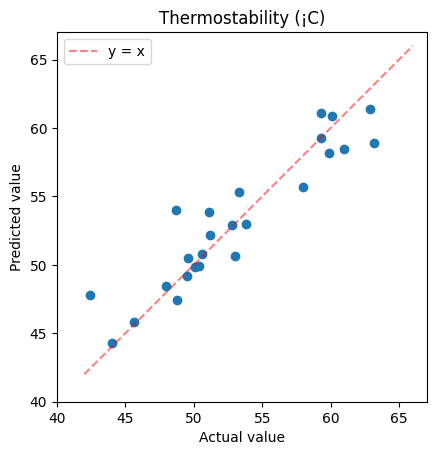

In [32]:
fig, ax = plt.subplots()

ax.scatter(y_test.detach().cpu()*(max_thermo - min_thermo) + min_thermo,
           y_test_pred.detach().cpu()*(max_thermo - min_thermo) + min_thermo
          )
ax.plot(np.arange(42,67), np.arange(42,67), '--', color='r', alpha=0.5, label='y = x')

ax.set_xlabel('Actual value')
ax.set_ylabel('Predicted value')

ax.set_xlim([40,67])
ax.set_ylim([40,67])

ax.set_title('Thermostability (¡C)')

ax.legend()

ax.set_aspect('equal', adjustable='box')

plt.show()

Both the plot and the $R^2$ score of about $0.85$ show a good performance of this simple LSTM model with just one layer and $64$ hidden units, given that I haven't performed any fine tuning.

To improve the model, a combination of different hyperparameters might be tested (like the number of LSTM layers, dimensionality of the hidden and cell representation, number of epochs, learning rate, etc). The introduction of Dropout can also be tested. In addition, advanced technique like learning rate scheduling might be introduced to dynamically change the learning rate to avoid local minima or slower convergence.

## Section 3: Using LLM's encoding

In the previous section I used one-hot encoding to create a suitable input for a recurrent architecture (LSTM). In this very short section, I will provide another solution which has become extremely popular in the last few years: LLMs.

LLMs are usually seq-to-seq model meaning that they are suited to work with input sequence data and output sequence data as well. To accomplish this, most LLMs are composed by two main substructures, an encoder and a decoder. The encoder aims to create embedded representations of the input sequence which is in turn passed to the decoder for the specific task to be accomplished.

For most open source LLMs, the encoder can be accessed separately. Using a pretrain encoder of a protein LLM, we can exploit a representation coming from a model which has condensed enormous amount of knowledge about proteins. Such representations can be used for a wide range of tasks, spanning from 3D protein folding structure prediction to regression problem like the scope of the report.

Given the time constraint, I will just show how to load a popular pretrained  model, ProtBERT, and extract the embeddings of the proteins in the dataset. ProtBERT has been trained on the Uniref100 dataset consisting of 217 million of protein sequences.

In [33]:
from transformers import BertModel, BertTokenizer

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
llm_model = BertModel.from_pretrained("Rostlab/prot_bert")

We can inspect the model architecture:

In [34]:
print(llm_model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30, 1024, padding_idx=0)
    (position_embeddings): Embedding(40000, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-29): 30 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.0, inpla

ProtBERT is composed of three main modules named embeddings, encoder and pooler. Let's use it to create embeddings for our proteins:

In [35]:
embeddings = []

for i in range(len(thermostability)):
    # ProtBERT is trained on sequence of 20 Amminoacids plus 'X' for uncommon ones. As such, the gap character is discarded
    sequence = thermostability['sequence'][i].replace('-', '') 
    encoded_input = tokenizer(sequence, return_tensors='pt')
    embed = llm_model(**encoded_input)
    embeddings.append(embed.pooler_output)

X_llm = torch.cat(embeddings).detach()

In [36]:
print(X_llm.shape)

torch.Size([261, 1024])


Each protein sequence is encoded in a 1024-dimensional vector. Such vectors can be used as input feature for other models, or the encoder can be fine-tuned for a specific task.

## Conclusion

In this report, I performed exploratory data analysis on a dataset of protein sequence activity data. I first checked that the sequences are in the expected format and there were no major issues in the dataset. I analised the distribution of the thermostability data and supported the data exploration with some visualisations.

I have preprocessed the data using one-hot encoding and normalisation to model the dataset using a bidirectional LSTM predicting the thermostability values with good performances, quantified by an $R^2$ score of about $0.85$.

Finally, I loaded a pretrained protein LLM from hugging face and used it to embed the protein sequences.

It was extremely interesting to work on this task and I've learned a lot. I'm very much looking forward to discuss my approach and receive any feedback. I'm available to answer any further question via email at sicurellaemanuele@gmail.com or to schedule a call.

_Emanuele Sicurella_

